## Initialize
1) relevant packages neede

In [ ]:
# Used packages
import pandas as pd
import numpy as np
from Functions import gdx_to_dict
from Functions import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from Dictionaries import fuel_colors
from Dictionaries import fuel_labels
from Dictionaries import area_to_region
import geopandas as gpd
import cartopy.crs as ccrs
import seaborn as sns
from geopy.geocoders import Nominatim

2) load .GDX files from scenarios

In [2]:
# Scenarios in GDX files contain three parameters with varying levels: Biomass availability, VRE resource, and fuel demand
# The following lists contain the scenarios in the GDX files
# The first letter refers to biomass avialability, the second to VRE resource, and the third to fuel demand, high, medium, or low
scenarios = ['HMM','MMM','LMM','HHM','MHM','LHM','HLM','MLM','LLM']
order_scenarios = ['LLM', 'LMM', 'LHM', 'MLM', 'MMM', 'MHM', 'HLM', 'HMM', 'HHM']
#scenarios = ['HMH','MMH','LMH','HHH','MHH','LHH','HLH','MLH','LLH']

symbolBal = ['G_CAP_YCRAF','CC_YCRAG','F_CONS_YCRA','OBJ_YCR','X_CAP_YCR','XH2_CAP_YCR','PRO_YCRAGF','XH2_FLOW_YCR','X_FLOW_YCR']
symbolOpti = ['VFLOWSOURCE_Opti_C','VFLOWTRANS_Opti_C','VFLOW_Opti_C','VFLOWCCU_C','VFLOW_Opti_A']

gams_directory = 'C:\\GAMS\\46'
file_path = 'C:\\Users\\tmad\\GitHub\\pap1-code\\Files'

GDXs = gdx_to_dict(symbolBal,symbolOpti,order_scenarios,gams_directory,file_path)

#res = MainResults(files=['MainResults_HHM.gdx','MainResults_HMM.gdx','MainResults_HLM.gdx','MainResults_MHM.gdx','MainResults_MMM.gdx','MainResults_MLM.gdx','MainResults_LHM.gdx','MainResults_LMM.gdx','MainResults_LLM.gdx'],
#                  paths=file_path,scenario_names=['HHM','HMM','HLM','MHM','MMM','MLM','LHM','LMM','LLM'])


c:\Users\tmad\GitHub\VREtradeoff\Functions.py:45: UserWarning: The GAMS version (46.2.0) differs from the API version (49.2.0).
  ws = gams.GamsWorkspace(system_directory=gams_sys_dir)


Finished, making dictionary of dataframes.



## Fuel production
To assess the impact of the parameters investigated (biomass, VRE, and demand), it is important to first show a baseline of which fuels are produced.
We also assess the distribution between biofuels, e-biofuels, and e-fuels.

In [3]:
df_fp = GDXs['VFLOW_Opti_C']
df_fp.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Fuel','level_3':'Demand','level_4':'Flow'},inplace=True)
demands = ['Air_fuels_sum','Road_fuels_sum','Sea_fuels_sum']
fuelproduction = df_fp[(df_fp['Demand'].isin(demands))]
years = fuelproduction['Year'].unique()
fuels = fuelproduction['Fuel'].unique()
# Group by Year, Scenario, and ProcFrom, then sum the values
fuelproduction_grouped = fuelproduction.groupby(['Year', 'Scenario', 'Fuel'])['Value'].sum().unstack()
# Reorder the index to the desired order
#order_scenarios = ['LLH', 'LMH', 'LHH', 'MLH', 'MMH', 'MHH', 'HLH', 'HMH', 'HHH']
order_fuels = ['Ammonia_Eff','EMethanol_Eff','EME_LPG_Eff','EME_Gasoline_Eff','EME_Jet_Eff','BioGasoline_Eff','BioJet_Eff']
fuels_label = ['Ammonia_Eff','EMethanol_Eff','EME_Jet_Eff','BioJet_Eff']
order_colors = [fuel_colors[fuel] for fuel in order_fuels]
order_labels = [fuel_labels[fuel] for fuel in order_fuels]
colors_leg = [fuel_colors[fuel] for fuel in fuels_label]
label_leg = [fuel_labels[fuel] for fuel in fuels_label]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors_leg[::-1], label_leg[::-1])]
fuelproduction_grouped = fuelproduction_grouped.reindex(order_scenarios, level='Scenario')
fuelproduction_grouped = fuelproduction_grouped.reindex(order_fuels, axis=1)
# Convert all values in the dataframe from PJ to TWh (1 PJ = 0.27778 TWh)
fuelproduction_grouped = fuelproduction_grouped * 0.27778
#fuelproduction_grouped.drop(columns=['Methanol_Eff'], inplace=True)


2) We furter find the distribution between biofuels, e-biofuels, and e-fuels.

In [4]:
## First we split biojet products
# Isolate biojet and split between biofuel and e-biofuel
bfset = ['BIOJETFLOW_BIO','BIOGASOLINEFLOW_BJ']
ebfset = ['BIOJETFLOW_H2','BIOGASOLINEFLOW_BJ_H2']
biojetprod = df_fp[(df_fp['Demand'].isin(['BioJet_SUM','BioGasoline_SUM']))]
biojetprod['Fuel'] = biojetprod['Flow'].apply(lambda x: 'Biofuel' if x in bfset else 'E-biofuel')
biojetprod_grouped = biojetprod.groupby(['Year', 'Scenario', 'Fuel'])['Value'].sum().unstack()
biojetprod_grouped = biojetprod_grouped.reindex(order_scenarios, level='Scenario')
biojetprod_grouped.fillna(0,inplace=True)

## Next we split upgraded methanol gasoline products
# Isolate methanol upgrading and split between e-biofuel and e-fuel (share)
methanolset = ['MethanolTotal','EMethanolTotal']
# upgrade input
methanolupg = df_fp[(df_fp['Demand'] == 'Methanol_Sum')]
# upgrade output
upgsum = df_fp[(df_fp['Fuel'] == 'EME_Upgrade_Sum')]
# find share of e-methanol to bio-methanol for upgrading
methanolupg['Fuel'] = methanolupg['Fuel'].apply(lambda x: 'E-biofuel' if x == 'MethanolTotal' else 'E-fuel')
methanolupg_grouped = methanolupg.groupby(['Year', 'Scenario', 'Fuel'])['Value'].sum().unstack()
methanolupg_grouped = methanolupg_grouped.reindex(order_scenarios, level='Scenario')
upgraded_methanol = methanolupg_grouped.div(methanolupg_grouped.sum(axis=1), axis=0)
#upgraded_methanol.fillna(0,inplace=True)
# order total methanol upgrading
upgsum_grouped = upgsum.groupby(['Year', 'Scenario', 'Fuel'])['Value'].sum().unstack()
upgsum_grouped = upgsum_grouped.reindex(order_scenarios, level='Scenario')
# split total methanol upgrading between e-biofuel and e-fuel
upgraded_methanol['E-fuel'] = upgraded_methanol['E-fuel'] * upgsum_grouped['EME_Upgrade_Sum']
try:
    upgraded_methanol['E-biofuel'] = upgraded_methanol['E-biofuel'] * upgsum_grouped['EME_Upgrade_Sum']
except:
    pass
#upgraded_methanol['E-biofuel'] = upgraded_methanol['E-biofuel'] * upgsum_grouped['EME_Upgrade_Sum']
upgraded_methanol = upgraded_methanol.reindex(order_scenarios, level='Scenario')
upgraded_methanol.fillna(0,inplace=True)


# Take remainder fuels that don't need splitting
ebiofuels = ['Methanol_Eff']
efuels = ['EMethanol_Eff','Ammonia_Eff','E_FT_Jet_Eff','E_FT_Diesel_Eff']
mix = ['BioJet_Eff','BioGasoline_Eff','EME_LPG_Eff','EME_Gasoline_Eff','EME_Jet_Eff']

aggfuelproduction = fuelproduction.copy()
aggfuelproduction = aggfuelproduction[~aggfuelproduction['Fuel'].isin(mix)]
aggfuelproduction['Fuel'] = aggfuelproduction['Fuel'].apply(lambda x: 'E-fuel' if x in efuels else ('E-biofuel' if x in ebiofuels else 'Biofuel'))
aggfuelproduction_grouped = aggfuelproduction.groupby(['Year', 'Scenario', 'Fuel'])['Value'].sum().unstack()
aggfuelproduction_grouped = aggfuelproduction_grouped.reindex(order_scenarios, level='Scenario')
#aggfuelproduction_grouped['Biofuel'] = 0
aggfuelproduction_grouped.fillna(0,inplace=True)
# Align dataframes
dfmain,dfalign = aggfuelproduction_grouped.align(upgraded_methanol,fill_value=0)
df = dfmain + dfalign
dfmain2,dfalign2 = df.align(biojetprod_grouped,fill_value=0)
df2= dfmain2 + dfalign2
df2 = df2.reindex(order_scenarios, level='Scenario')
df2 = df2.reindex(['E-fuel','E-biofuel','Biofuel'],axis=1)
# Normalize the values to sum to 1
combined_fuelproduction_normalized = df2.div(df2.sum(axis=1), axis=0)



C:\Users\tmad\AppData\Local\Temp\ipykernel_18716\2479274772.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biojetprod['Fuel'] = biojetprod['Flow'].apply(lambda x: 'Biofuel' if x in bfset else 'E-biofuel')
C:\Users\tmad\AppData\Local\Temp\ipykernel_18716\2479274772.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  methanolupg['Fuel'] = methanolupg['Fuel'].apply(lambda x: 'E-biofuel' if x == 'MethanolTotal' else 'E-fuel')


3) We then plot the two in a combined plot.

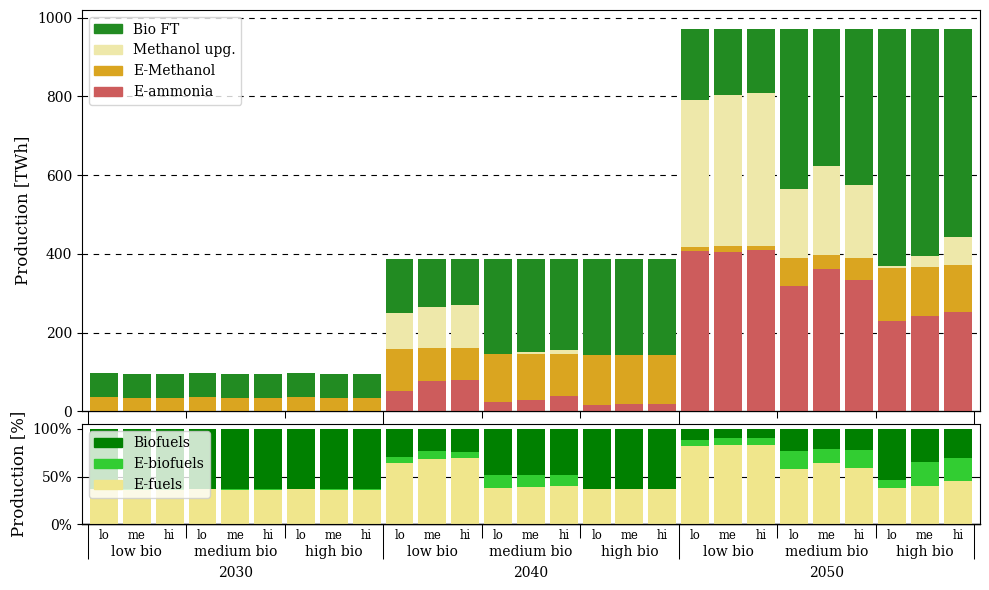

In [5]:
plt.rcParams["font.family"] = "serif"
# Create a figure with two subplots, one on top of the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),height_ratios=[4, 1])

# Plot the first chart (Fuel Production by Year and Scenario)
fuelproduction_grouped.plot(kind='bar', stacked=True, color=order_colors, width=0.85, ax=ax1)
# Set the title and labels for the first chart
ax1.set_ylabel('Production [TWh]',fontsize='large')
ax1.set_xlabel('')
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.legend(handles=legend_patches, loc='upper left',fontsize='medium')
sec1 = ax1.secondary_xaxis(location=0)
sec1.set_xticks([-0.5,8.5, 17.5, 26.5],labels=[])
sec1.tick_params('x',length=10,width=0.75)
sec11 = ax1.secondary_xaxis(location=0)
sec11.set_xticks([2.5,5.5,11.5,14.5,20.5,23.5],labels=[])
sec11.tick_params('x',length=5,width=0.75)

# Add dashed lines for each 1000 on the y-axis for the first chart
for y in np.arange(200, 1200, 200):
    ax1.axhline(y=y, color='black', linestyle=(0, (5, 5)), linewidth=0.8, zorder=0)

# Plot the second chart (Share of Bio-fuels and E-fuels by Year and Scenario)
combined_fuelproduction_normalized.plot(kind='bar', stacked=True, color=['khaki','limegreen','green'], width=0.85, ax=ax2)
legend_patches2 = [mpatches.Patch(color=color, label=label) for color, label in zip(['green','limegreen','khaki'], ['Biofuels','E-biofuels','E-fuels'])]
# Set the title and labels for the second chart
ax2.set_xlabel('')
ax2.set_ylabel('Production [%]',fontsize='large')
ax2.tick_params(axis='x', bottom=False, labelbottom=False)
ax2.legend(handles=legend_patches2, loc='upper left',fontsize='medium')
sec2 = ax2.secondary_xaxis(location=0)
sec2.set_xticks([-0.5,8.5, 17.5, 26.5],labels=[])
sec2.tick_params('x',length=25,width=0.75)
sec21 = ax2.secondary_xaxis(location=0)
sec21.set_xticks([2.5,5.5,11.5,14.5,20.5,23.5],labels=[])
sec21.tick_params('x',length=10,width=0.75)
sec22 = ax2.secondary_xaxis(location=0)
sec22.set_xticks([4,13,22],labels=['2030','2040','2050'])
sec22.tick_params('x',length=0,width=0.75, pad=30)
sec23 = ax2.secondary_xaxis(location=0)
sec23.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26],labels=['lo','me','hi','lo','me','hi','lo','me','hi','lo','me','hi','lo','me','hi','lo','me','hi','lo','me','hi','lo','me','hi','lo','me','hi'],fontsize='small')
sec23.tick_params('x',length=0,width=0.75)
sec24 = ax2.secondary_xaxis(location=0)
sec24.set_xticks([1,4,7,10,13,16,19,22,25],labels=['low bio','medium bio','high bio','low bio','medium bio','high bio','low bio','medium bio','high bio'])
sec24.tick_params('x',length=0,width=0.75,pad=15)


# Change the y-axis to percentage for the second chart
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add dashed lines for each 0.2 on the y-axis for the second chart
for y in np.arange(0.5, 1.0, 0.5):
    ax2.axhline(y=y, color='black', linestyle='-', linewidth=0.8, zorder=0)

# Adjust the spacing between subplots
plt.tight_layout()

plt.subplots_adjust(hspace=0.05)

# Show the combined plot
plt.show()

## Mini heatmap

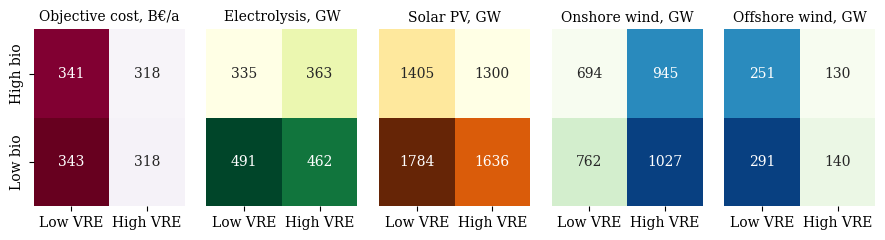

In [3]:
# Read capacity file
df_G = GDXs['G_CAP_YCRAF']
df_G.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Commodity','level_7':'Technology','level_8':'Variable','level_9':'Unit'},inplace=True)
# Read production file
df_P = GDXs['PRO_YCRAGF']
df_P.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Commodity','level_7':'Technology','level_8':'Unit'},inplace=True)
# Read objective function
df_OB = GDXs['OBJ_YCR']
df_OB.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Category','level_4':'Unit'},inplace=True)

# Settings
year = '2050'
mainscenario = 'HHM'
scnd = 'HLM'
thrd = 'LHM' 
frth = 'LLM'
allscenario = [mainscenario,scnd,thrd,frth]

# mini heat
mapbio = {'L':'Low bio','H':'High bio'}
mapvre = {'L':'Low VRE','H':'High VRE'}

obj = df_OB[(df_OB['Year'] == year) & (df_OB['Scenario'].isin(allscenario))]
obj = obj.groupby(['Scenario'])['Value'].sum()/1e3
obj = obj.reset_index()
obj['Biomass'] = obj['Scenario'].str[0].map(mapbio)
obj['VRE'] = obj['Scenario'].str[1].map(mapvre)
obj = obj.pivot(index='Biomass',columns='VRE',values='Value')
obj = obj[['Low VRE','High VRE']]

elec = df_G[(df_G['Technology'] == 'ELECTROLYZER') & (df_G['Year'] == year) & (df_G['Scenario'].isin(allscenario))]
elec = elec.groupby(['Scenario'])['Value'].sum()
elec = elec.reset_index()
elec['Biomass'] = elec['Scenario'].str[0].map(mapbio)
elec['VRE'] = elec['Scenario'].str[1].map(mapvre)
elec = elec.pivot(index='Biomass',columns='VRE',values='Value')
elec = elec[['Low VRE','High VRE']]

sun = df_G[(df_G['Technology'] == 'SOLAR-PV') & (df_G['Year'] == year) & (df_G['Scenario'].isin(allscenario))]
sun = sun.groupby(['Scenario'])['Value'].sum()
sun = sun.reset_index()
sun['Biomass'] = sun['Scenario'].str[0].map(mapbio)
sun['VRE'] = sun['Scenario'].str[1].map(mapvre)
sun = sun.pivot(index='Biomass',columns='VRE',values='Value')
sun = sun[['Low VRE','High VRE']]

on = df_G[(df_G['Technology'] == 'WIND-ON') & (df_G['Year'] == year) & (df_G['Scenario'].isin(allscenario))]
on = on.groupby(['Scenario'])['Value'].sum()
on = on.reset_index()
on['Biomass'] = on['Scenario'].str[0].map(mapbio)
on['VRE'] = on['Scenario'].str[1].map(mapvre)
on = on.pivot(index='Biomass',columns='VRE',values='Value')
on = on[['Low VRE','High VRE']]

off = df_G[(df_G['Technology'] == 'WIND-OFF') & (df_G['Year'] == year) & (df_G['Scenario'].isin(allscenario))]
off = off.groupby(['Scenario'])['Value'].sum()
off = off.reset_index()
off['Biomass'] = off['Scenario'].str[0].map(mapbio)
off['VRE'] = off['Scenario'].str[1].map(mapvre)
off = off.pivot(index='Biomass',columns='VRE',values='Value')
off = off[['Low VRE','High VRE']]

plt.rcParams["font.family"] = "serif"

fig, axes = plt.subplots(1, 5, figsize=(9, 2.5))
sns.heatmap(obj, annot=True, fmt=".0f", cmap='PuRd', cbar=False, ax=axes[0], annot_kws={"size": 10})
sns.heatmap(elec, annot=True, fmt=".0f", cmap='YlGn', cbar=False, ax=axes[1], annot_kws={"size": 10})
sns.heatmap(sun, annot=True, fmt=".0f", cmap='YlOrBr', cbar=False, ax=axes[2], annot_kws={"size": 10})
sns.heatmap(on, annot=True, fmt=".0f", cmap='GnBu', cbar=False, ax=axes[3], annot_kws={"size": 10})
sns.heatmap(off, annot=True, fmt=".0f", cmap='GnBu', cbar=False, ax=axes[4], annot_kws={"size": 10})

axes[0].set_title('Objective cost, B€/a', fontsize=10)
axes[1].set_title('Electrolysis, GW', fontsize=10)
axes[2].set_title('Solar PV, GW', fontsize=10)
axes[3].set_title('Onshore wind, GW', fontsize=10)
axes[4].set_title('Offshore wind, GW', fontsize=10)
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')
axes[4].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[3].set_xlabel('')
axes[4].set_xlabel('')
axes[1].tick_params(axis='y', left=False, labelleft=False)
axes[2].tick_params(axis='y', left=False, labelleft=False)
axes[3].tick_params(axis='y', left=False, labelleft=False)
axes[4].tick_params(axis='y', left=False, labelleft=False)
axes[0].tick_params(axis='x', labelrotation=0)
axes[1].tick_params(axis='x', labelrotation=0)
axes[2].tick_params(axis='x', labelrotation=0)
axes[3].tick_params(axis='x', labelrotation=0)
axes[4].tick_params(axis='x', labelrotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# Capacity factors and more


## Sankey

In [9]:
## Make sankey

# Sankey
#nodes = ['Biogas','Woody biomass','Agricultural biomass','Industry','Other','Transport','Combustion CC','Combustion','Fuels', 'DAC','CO2','Fossil CC','Sequestration','Use'] 
nodes = ['Biomass','Industry','Other','Transport','Combustion CC','Combustion','Fuels', 'Biogas','DAC','CO2','Fossil CC','Sequestration','Use']
agriculture = ['STRAW']
biogas = ['BIOGAS']
woody = ['WOODCHIPS','WOODPELLETS']
biomass = agriculture + biogas + woody
biomass2 = ['Agricultural biomass','Biogas','Woody biomass']
year = '2050'
scenario = 'MMM'

# Get OptiFlow and Balmorel data
df_opt = GDXs['VFLOWCCU_C']
df_opt.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Source','level_3':'Flow'},inplace=True)
opti = df_opt.copy()
df_opt2 = GDXs['VFLOW_Opti_C']
df_opt2.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Source','level_3':'Destination','level_4':'Flow'},inplace=True)
opti2 = df_opt2.copy()
df_cc = GDXs['CC_YCRAG']
df_cc.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
carbcap = df_cc.copy()
df_g = GDXs['F_CONS_YCRA']
df_g.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region','level_3':'Area','level_4':'Generator','level_5':'Fuel','level_6':'Technology','level_7':'Unit'},inplace=True)
bal = df_g.copy()
bal['Fuel'] = bal['Fuel'].apply(lambda x: 'Biomass' if x in biomass else x)
#bal['Fuel'] = bal['Fuel'].apply(lambda x: 'Agricultural biomass' if x in agriculture else x)
#bal['Fuel'] = bal['Fuel'].apply(lambda x: 'Biogas' if x in biogas else x)
#bal['Fuel'] = bal['Fuel'].apply(lambda x: 'Woody biomass' if x in woody else x)
bal['Area'] = bal['Area'].apply(lambda x: 'Industry' if '_IND' in x else 'Conventional')

# Biomass use
bio_fuel = bal[(bal['Technology'] == 'OPTIFLOW') & (bal['Fuel'] == 'Biomass')].groupby(['Scenario','Year'])['Value'].sum().unstack()
bio_fuel = bio_fuel.loc[scenario][year]
#agri_fuel = bal[(bal['Technology'] == 'OPTIFLOW') & (bal['Fuel'] == 'Agricultural biomass')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#agri_fuel = agri_fuel.loc[scenario][year]
#wood_fuel = bal[(bal['Technology'] == 'OPTIFLOW') & (bal['Fuel'] == 'Woody biomass')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#wood_fuel = wood_fuel.loc[scenario][year]
bio_ind = bal[(bal['Fuel'] == 'Biomass') & (bal['Area'] == 'Industry')].groupby(['Scenario','Year'])['Value'].sum().unstack()
bio_ind = bio_ind.loc[scenario][year]
#agri_ind = bal[(bal['Fuel'] == 'Agricultural biomass') & (bal['Area'] == 'Industry')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#try:
    #agri_ind = agri_ind.loc[scenario][year]
#except:
#    agri_ind = 0
bio_other = bal[(bal['Fuel'] == 'Biomass') & (bal['Area'] == 'Conventional') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
bio_other = bio_other.loc[scenario][year]
#agri_other = bal[(bal['Fuel'] == 'Agricultural biomass') & (bal['Area'] == 'Conventional') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#try:
#    agri_other = agri_other.loc[scenario][year]
#except:
#    agri_other = 0
#wood_ind = bal[(bal['Fuel'] == 'Woody biomass') & (bal['Area'] == 'Industry')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#wood_ind = wood_ind.loc[scenario][year]
#wood_other = bal[(bal['Fuel'] == 'Woody biomass') & (bal['Area'] == 'Conventional') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#wood_other = wood_other.loc[scenario][year]
#biogas_ind = bal[(bal['Fuel'] == 'Biogas') & (bal['Area'] == 'Industry')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#biogas_ind = biogas_ind.loc[scenario][year]
#biogas_other = bal[(bal['Fuel'] == 'Biogas') & (bal['Area'] == 'Conventional') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
#biogas_other = biogas_other.loc[scenario][year]

# Biomass combustion
ind_CC = bal[(bal['Generator'].str.contains('CCS')) & (bal['Area'] == 'Industry') & (bal['Fuel'] == 'Biomass') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
ind_CC = ind_CC.loc[scenario][year]
other_CC = bal[(bal['Generator'].str.contains('CCS')) & (bal['Area'] == 'Conventional') & (bal['Fuel'] == 'Biomass') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
try:
    other_CC = other_CC.loc[scenario][year]
except:
    other_CC = 0
ind_noCC = bal[(~bal['Generator'].str.contains('CCS')) & (bal['Area'] == 'Industry') & (bal['Fuel'] == 'Biomass') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
ind_noCC = ind_noCC.loc[scenario][year]
other_noCC = bal[(~bal['Generator'].str.contains('CCS')) & (bal['Area'] == 'Conventional') & (bal['Fuel'] == 'Biomass') & (bal['Technology'] != 'OPTIFLOW')].groupby(['Scenario','Year'])['Value'].sum().unstack()
other_noCC = other_noCC.loc[scenario][year]

# transport
#fuel_transp = agri_fuel + wood_fuel
fuel_transp = bio_fuel

# Carbon capture
carbcap_bio = carbcap[(carbcap['Fuel'].isin(biomass))] # kton
carbcap_bio = carbcap_bio.groupby(['Scenario','Year'])['Value'].sum().unstack()
try:
    carbcap_bio = carbcap_bio.loc[scenario][year]
except:
    carbcap_bio = 0
carbcap_fossil = carbcap[(~carbcap['Fuel'].isin(biomass))] # kton
carbcap_fossil = carbcap_fossil.groupby(['Scenario','Year'])['Value'].sum().unstack()
carbcap_fossil = carbcap_fossil.loc[scenario][year] / 1e3 # Mton

# Carbon use
opti_biogen = opti[(opti['Source'] == 'CO2_Source_Biogen')] # ton
CCU_biogen = opti_biogen.groupby(['Scenario','Year'])['Value'].sum().unstack()
CCU_biogen.fillna(0, inplace=True)
CCU_biogen = CCU_biogen.loc[scenario][year] / 1e3 # kton
CCU_biogas = opti2[(opti2['Source'] == 'CO2_Bio_Pot') & (opti2['Destination'] == 'CO2')] # ton
CCU_biogas = CCU_biogas.groupby(['Scenario','Year'])['Value'].sum().unstack()
CCU_biogas = CCU_biogas.loc[scenario][year] *1e3 # kton
try:
    opti_DAC = opti2[(opti2['Source'] == 'CO2_Source_DAC')] # ton
    opti_DAC_grouped = opti_DAC.groupby(['Scenario','Year'])['Value'].sum().unstack()
    opti_DAC_grouped.fillna(0, inplace=True)
    opti_DAC_grouped = opti_DAC_grouped.loc[scenario][year] * 1e3 # kton
except:
    opti_DAC_grouped = 0
    
# Share carbon use
share = CCU_biogen / carbcap_bio
industryCCU = share * ind_CC
otherCCU = share * other_CC
industryCCS = (1-share) * ind_CC
otherCCS = (1-share) * other_CC
CCU = (CCU_biogen + CCU_biogas + opti_DAC_grouped) / 1e3 # Mton
CCS = (carbcap_bio - CCU_biogen)/1e3 # Mton

biomass_sum = bio_fuel + bio_ind + bio_other
#agriculture = agri_fuel + agri_ind + agri_other
#woody = np.nansum([wood_fuel, wood_ind, wood_other])
#biogas = np.nansum([biogas_ind, biogas_other])
#biomass = np.nansum([agriculture,woody,biogas])
co2_scale = 2
co2_bg = CCU_biogas/1e3 * co2_scale
co2_biogen = CCU_biogen/1e3 * co2_scale
co2_DAC = opti_DAC_grouped/1e3 * co2_scale
CCS = CCS * co2_scale
CCU = CCU * co2_scale
carbcap_fossil = carbcap_fossil * co2_scale
co2 = np.nansum([co2_bg, co2_biogen, co2_DAC, CCS])

#fossil = foss_CC
fuels = fuel_transp
combustionCC = np.nansum([ind_CC, other_CC])
combustion = np.nansum([ind_noCC, other_noCC])
transport = fuel_transp
industry = np.nansum([ind_CC, ind_noCC])
other = np.nansum([other_CC, other_noCC])


In [11]:
#nodes = ['Biogas','Woody biomass','Agricultural biomass','Industry','Other','Transport','Combustion CC','Combustion','Fuels', 'DAC','CO2','Fossil CC','Sequestration','Use'] 
# level 1 = [Biogas, Woody biomass, Agricultural biomass] 0,1,2
# level 2 = [Industry, Other, Transport]                  3,4,5
# level 3 = [Combustion CC, Combustion, Fuels, DAC]       6,7,8,9
# level 4 = [CO2, Fossil CC]                              10,11
# level 5 = [Sequestration, Use]                          12,13

#nodes = ['Biomass','Industry','Other','Transport','Combustion CC','Combustion','Fuels', 'Biogas','DAC','CO2','Fossil CC','Sequestration','Use']
# level 1 = [Biomass]                                       0
# level 2 = [Industry, Other, Transport]                    1,2,3
# level 3 = [Combustion CC, Combustion, Fuels, Biogas, DAC] 4,5,6,7
# level 4 = [CO2, Fossil CC]                                8,9
# level 5 = [Sequestration, Use]                            10,11

source = 0.01
sector = 0.27
use = 0.5
carb = 0.75
sink = 0.99

# Plot sankey
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = nodes,
      #x = [source, source, source,
      #     sector, sector, sector,
      #     use, use, use, use*1.1,
      #     carb, carb*1,
      #     sink, sink],
      x = [source,
           sector, sector, sector,
           use, use, use, use*1.1, use*1.1,
           carb, carb*1,
           sink, sink],
      y = [0.5,
           0.2, 0.4, 0.7,
           0.05, 0.25, 0.7, 0.4, 0.6,
           0.25, 0.80,
           0.6, 0.15],
      color = "lightgrey"
    ),
    link = dict(
      #source = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 0,  6,  9,  10, 10, 11],
      source = [0, 0, 0, 1, 1, 2, 2, 3, 4, 7, 8, 9, 9, 10],
      target = [1, 2, 3, 4, 5, 4, 5, 6, 9, 9, 9, 11, 12, 11],
      #target = [3, 4, 3, 4, 5, 3, 4, 5, 6, 7, 6, 7, 8, 10, 10, 10, 12, 13, 12],
      #value =  [biogas_ind, biogas_other, wood_ind, wood_other, wood_fuel, agri_ind, agri_other, agri_fuel,
      #          ind_CC, ind_noCC, other_CC, other_noCC, fuel_transp,
      #          co2_bg, co2_biogen, co2_DAC,
      #          CCS, CCU, carbcap_fossil],
      value =  [bio_ind, bio_other, bio_fuel,
                ind_CC, ind_noCC, other_CC, other_noCC, fuel_transp,
                co2_biogen, co2_bg, co2_DAC,
                CCS, CCU, carbcap_fossil],                
      color =  ['forestgreen','forestgreen','forestgreen',
                'bisque','orange','bisque','orange','lightgray',
                'darkslategray','darkslategray','darkslategray',
                'darkslategray','lightslategray','gray']
  ))])

#fig.update_layout(font_size=16,width=700,font_family="serif",font_color="black")
# Update the labels to include the values
fig.update_traces(node=dict(label=[
#  f'Biogas, {biogas:.0f}', 
#  f'Woody, {woody:.0f}',
#  f'Agricultural, {agriculture:.0f}',
  f'Biomass, {biomass_sum:.0f}',
  f'Industry, {industry:.0f}',
  f'Other, {other:.0f}',
  f'Transport, {fuel_transp:.0f}',  
  f'Combustion CC, {combustionCC:.0f}', 
  f'Combustion, {combustion:.0f}',
  f'Fuels, {fuels:.0f}',
  f'Biogas, {co2_bg/co2_scale:.0f}',
  f'DAC, {co2_DAC/co2_scale:.0f}',
  f'CO2, {co2/co2_scale:.0f}',
  f'Fossil CCS, {carbcap_fossil/co2_scale:.0f}',
  f'Sequestration, {(CCS+carbcap_fossil)/co2_scale:.0f}',
  f'Use, {CCU/co2_scale:.0f}'
]))

heights = {"H":450,"M":350,"L":250}
labels = {"HH":"i)","HL":"ii)","MH":"iii)","ML":"iv)","LH":"v)","LL":"vi)","MM":"test)"}
height = heights[scenario[0]]
label = labels[scenario[:2]]
#scaled_height_HHM = 484
#scaled_height_HLM = 599
fig.update_layout(height=height,margin=dict(l=5, r=5, t=40, b=40),font_size=26,width=900,font_family="Calibri",font_color="black",plot_bgcolor="black")

if scenario[0]=="L":
    
  fig.add_shape(type="line",
        x0=0, y0=0.02, x1=0.52, y1=0.02,
        line=dict(color="black", width=2))
  fig.add_shape(type="line",
        x0=0.53, y0=0.02, x1=1, y1=0.02,
        line=dict(color="black", width=2))

  fig.add_annotation(x=0.275, y=-0.2, text="TWh", showarrow=False, font=dict(size=24))
  fig.add_annotation(x=0.775, y=-0.2, text="Mt", showarrow=False, font=dict(size=24))

fig.add_annotation(x=0, y=1.08, text=label, showarrow=False, font=dict(size=24))

# Save the figure as a high resolution image
#fig.write_image("C:\\Users\\tmad\\OneDrive - Danmarks Tekniske Universitet\\11 BioLim PtX\\Figures\\Sank_"+scenario+".png")
fig.show()


## Initialize full

In [1]:
# Used packages
import pandas as pd
import numpy as np
from Functions import gdx_to_dict
from Functions import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from Dictionaries import fuel_colors
from Dictionaries import fuel_labels
from Dictionaries import change_country_label
import geopandas as gpd
import cartopy.crs as ccrs
from pybalmorel import MainResults
import seaborn as sns

gams_directory = 'C:\\GAMS\\46'
file_path = 'C:\\Users\\tmad\\GitHub\\pap1-code\\Files'

# Load full data
scen = ['HHH','HHM','HHL','HMH','HMM','HML','HLH','HLM','HLL','MHH','MHM','MHL','MMH','MMM','MML','MLH','MLM','MLL','LHH','LHM','LHL','LMH','LMM','LML','LLH','LLM','LLL']
bal = ['F_CONS_YCRA','G_CAP_YCRAF','X_CAP_YCR','XH2_CAP_YCR','CC_YCRAG']
opt = ['VFLOWCCU_C','VFLOW_Opti_C']
GDX_full = gdx_to_dict(bal,opt,scen,gams_directory,file_path)

c:\Users\tmad\GitHub\pap1-code\Functions.py:45: UserWarning: The GAMS version (46.2.0) differs from the API version (48.1.0).
  ws = gams.GamsWorkspace(system_directory=gams_sys_dir)


Finished, making dictionary of dataframes.



## Heat map 2

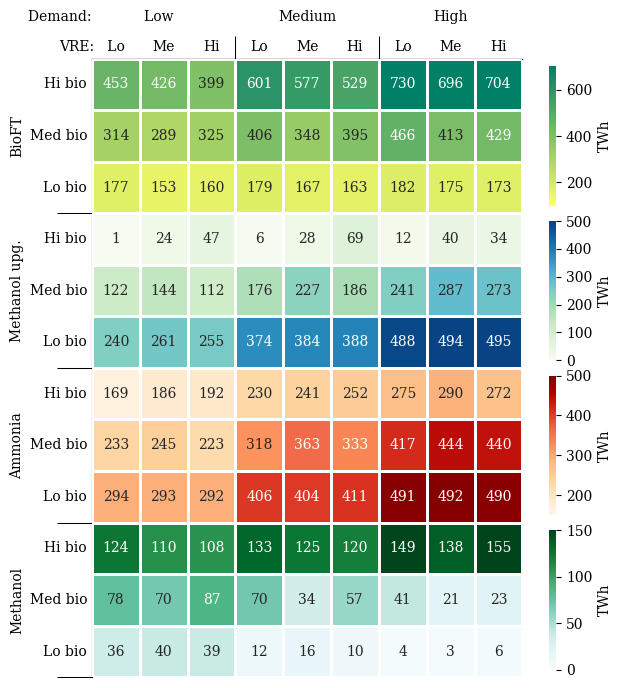

In [35]:
# Fuel production
df_production = GDX_full['VFLOW_Opti_C']
df_production.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Source','level_3':'Destination','level_4':'Flow'},inplace=True)

bioFT = ['BioJet_Eff','BioGasoline_Eff']
methupg = ['EME_Gasoline_Eff','EME_LPG_Eff','EME_Jet_Eff']
ammonia = ['Ammonia_Eff']
methanol = ['Methanol_Eff','EMethanol_Eff']

year = '2050'
biomass_order = ['Hi bio','Med bio','Lo bio']
VRE_Demand_order = [('L','L'),('M','L'),('H','L'),('L','M'),('M','M'),('H','M'),('L','H'),('M','H'),('H','H')]

mapbio = {'L':'Lo bio', 'M':'Med bio','H':'Hi bio'}

length = 25
width = 0.75

plt.rcParams["font.family"] = "serif"

BioJet = df_production[(df_production['Year'] == year) & (df_production['Destination'].isin(bioFT)) & (~df_production['Source'].str.contains('Exim'))]
BioJet = BioJet.groupby('Scenario')['Value'].sum() / 3.6 # PJ -> TWh
BioJet = BioJet.reset_index()
BioJet['Biomass'] = BioJet['Scenario'].str[0].map(mapbio)
BioJet['VRE'] = BioJet['Scenario'].str[1]
BioJet['Demand'] = BioJet['Scenario'].str[2]
BioJet = BioJet.pivot(index='Biomass', columns=['VRE','Demand'], values='Value')
BioJet = BioJet.reindex(biomass_order, axis=0)
BioJet = BioJet[VRE_Demand_order]

Methupg = df_production[(df_production['Year'] == year) & (df_production['Destination'].isin(methupg)) & (~df_production['Source'].str.contains('Exim'))]
Methupg = Methupg.groupby('Scenario')['Value'].sum() / 3.6 # PJ -> TWh
Methupg = Methupg.reset_index()
Methupg['Biomass'] = Methupg['Scenario'].str[0].map(mapbio)
Methupg['VRE'] = Methupg['Scenario'].str[1]
Methupg['Demand'] = Methupg['Scenario'].str[2]
Methupg = Methupg.pivot(index='Biomass', columns=['VRE','Demand'], values='Value')
Methupg = Methupg.reindex(biomass_order, axis=0)
Methupg = Methupg[VRE_Demand_order]

Ammonia = df_production[(df_production['Year'] == year) & (df_production['Destination'].isin(ammonia)) & (~df_production['Source'].str.contains('Exim'))]
Ammonia = Ammonia.groupby('Scenario')['Value'].sum() / 3.6 # PJ -> TWh
Ammonia = Ammonia.reset_index()
Ammonia['Biomass'] = Ammonia['Scenario'].str[0].map(mapbio)
Ammonia['VRE'] = Ammonia['Scenario'].str[1]
Ammonia['Demand'] = Ammonia['Scenario'].str[2]
Ammonia = Ammonia.pivot(index='Biomass', columns=['VRE','Demand'], values='Value')
Ammonia = Ammonia.reindex(biomass_order, axis=0)
Ammonia = Ammonia[VRE_Demand_order]

Methanol = df_production[(df_production['Year'] == year) & (df_production['Destination'].isin(methanol)) & (~df_production['Source'].str.contains('Exim'))]
Methanol = Methanol.groupby('Scenario')['Value'].sum() / 3.6 # PJ -> TWh
Methanol = Methanol.reset_index()
Methanol['Biomass'] = Methanol['Scenario'].str[0].map(mapbio)
Methanol['VRE'] = Methanol['Scenario'].str[1]
Methanol['Demand'] = Methanol['Scenario'].str[2]
Methanol = Methanol.pivot(index='Biomass', columns=['VRE','Demand'], values='Value')
Methanol = Methanol.reindex(biomass_order, axis=0)
Methanol = Methanol[VRE_Demand_order]

fig, axes = plt.subplots(4, 1, figsize=(6.5, 7))

sns.heatmap(BioJet, annot=True, fmt='.0f', cmap='summer_r', ax=axes[0], cbar=True,linewidths=1,vmax=700,vmin=100, cbar_kws={'label': 'TWh','shrink': 0.9})
sns.heatmap(Methupg, annot=True, fmt='.0f', cmap='GnBu', ax=axes[1], cbar=True,linewidths=1,vmax=500,vmin=0, cbar_kws={'label': 'TWh','shrink': 0.9})
sns.heatmap(Ammonia, annot=True, fmt='.0f', cmap='OrRd', ax=axes[2], cbar=True,linewidths=1,vmax=500,vmin=150, cbar_kws={'label': 'TWh','shrink': 0.9})
sns.heatmap(Methanol, annot=True, fmt='.0f', cmap='BuGn', ax=axes[3], cbar=True,linewidths=1,vmax=150,vmin=0, cbar_kws={'label': 'TWh','shrink': 0.9})

# Adjust the layout
axes[0].xaxis.tick_top()
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[3].set_xlabel('')
axes[0].set_ylabel('BioFT')
axes[1].set_ylabel('Methanol upg.')
axes[2].set_ylabel('Ammonia')
axes[3].set_ylabel('Methanol')
axes[0].tick_params(axis='x',top=False,labeltop=False)
axes[1].tick_params(axis='x',bottom=False,labelbottom=False)
axes[2].tick_params(axis='x',bottom=False,labelbottom=False)
axes[3].tick_params(axis='x',bottom=False,labelbottom=False)
axes[0].tick_params(axis='y',length=0)
axes[1].tick_params(axis='y',length=0)
axes[2].tick_params(axis='y',length=0)
axes[3].tick_params(axis='y',length=0)

sec00 = axes[0].secondary_xaxis(location=1)
sec00.set_xticks([3,6],labels=[])
sec00.tick_params('x',length=length/1.5,width=width)
sec0 = axes[0].secondary_yaxis(location=0)
sec0.set_yticks([3],labels=[])
sec0.tick_params('y',length=length,width=width)
sec1 = axes[1].secondary_yaxis(location=0)
sec1.set_yticks([3],labels=[])
sec1.tick_params('y',length=length,width=width)
sec2 = axes[2].secondary_yaxis(location=0)
sec2.set_yticks([3],labels=[])
sec2.tick_params('y',length=length,width=width)
sec3 = axes[3].secondary_yaxis(location=0)
sec3.set_yticks([3],labels=[])
sec3.tick_params('y',length=length,width=width)

sectop = axes[0].secondary_xaxis(location=1)
sectop.set_xticks([0.18,4.5,7.5],labels=['Demand:            Low','Medium','High'])
sectop.tick_params('x',length=0,width=0.75, pad=25)
sectop2 = axes[0].secondary_xaxis(location=1)
sectop2.set_xticks([0,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5],labels=['VRE:   Lo','Me','Hi','Lo','Me','Hi','Lo','Me','Hi'])
sectop2.tick_params('x',length=0,width=0.75)

# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0)


## Pipeline plot

C:\Users\tmad\AppData\Local\Temp\ipykernel_17236\3372232288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_capacity['Country'] = hydrogen_capacity['Country'].map(change_country_label)


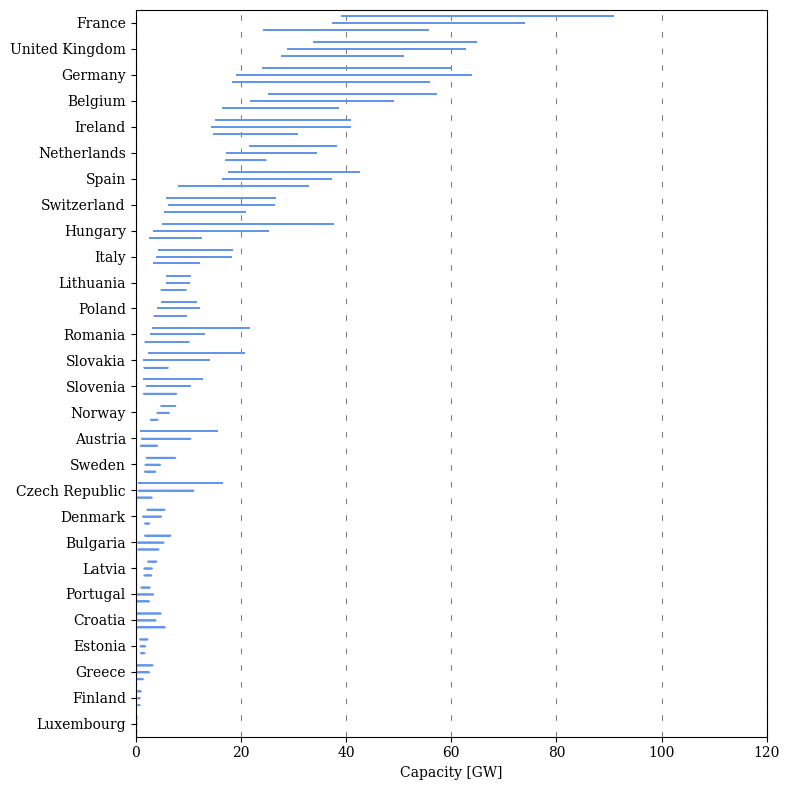

In [10]:
# Setting
year = '2050'

# Load data
df_XH2 = GDX_full['XH2_CAP_YCR']
df_XH2.rename(columns={'level_0':'Year','level_1':'Country','level_2':'Region1','level_3':'Region2','level_4':'Variable','level_9':'Unit'},inplace=True)
hydrogen_capacity = df_XH2[(df_XH2['Year'] == year)]
hydrogen_capacity['Country'] = hydrogen_capacity['Country'].map(change_country_label)
hydrogen_capacity_all = hydrogen_capacity.groupby(['Country','Scenario'])['Value'].sum()
hydrogen_capacity_ordered = hydrogen_capacity.groupby(['Country'])['Value'].sum().sort_values(ascending=False)
hydrogen_capacity_all = hydrogen_capacity_all.reset_index()
hydrogen_capacity_all['Demand'] = hydrogen_capacity_all['Scenario'].str[2]
hydrogen_capacity_all['Demand'] = hydrogen_capacity_all['Demand'].map({'L':'Low','M':'Medium','H':'High'})

plt.rcParams["font.family"] = "serif"

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
vp = sns.violinplot(y ="Country", x ="Value", hue="Demand", legend=False, data = hydrogen_capacity_all, ax=axes, cut=0, hue_order=['High','Medium','Low'], order=hydrogen_capacity_ordered.index, dodge=True, inner='stick', gap=0.5, fill = True, linecolor='cornflowerblue')
axes.xaxis.set_label_text('Capacity [GW]')
axes.yaxis.set_label_text('')
axes.set_xlim(0, 120)

for x in np.arange(0, 140, 20):
    axes.axvline(x=x, color='grey', linestyle=(0,(5,10)), linewidth=0.8, zorder=0)

plt.tight_layout()
